In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización: Top 10 programas más transmitidos

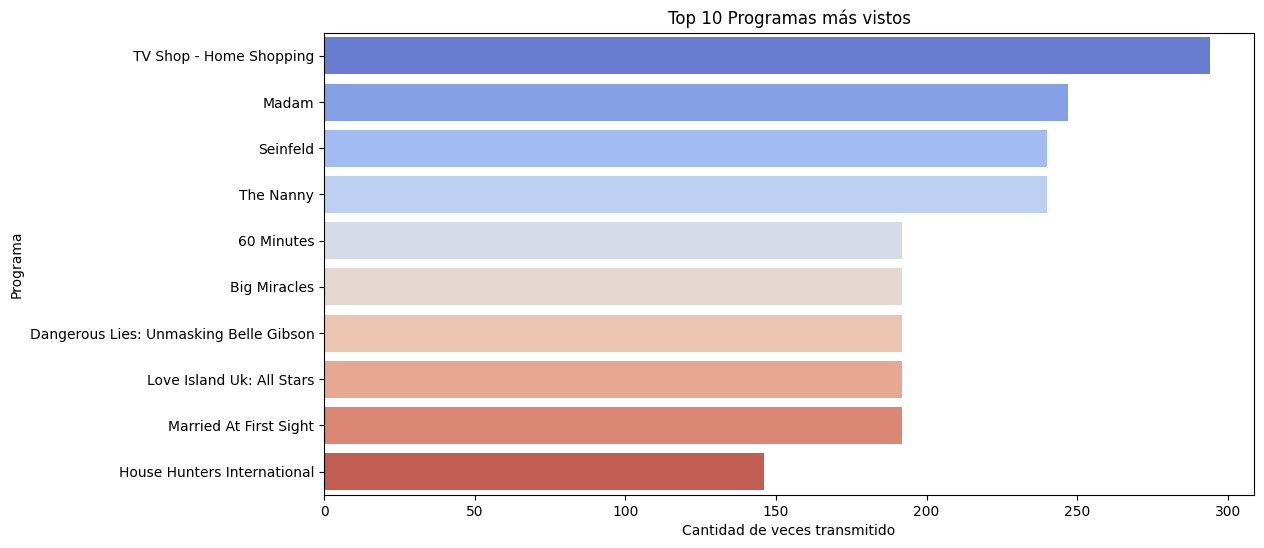

In [ ]:
# Cargar el CSV generado con Selenium
csv_filename = 'tv_guide_by_city.csv'
df = pd.read_csv(csv_filename)

# Visualización: Top 10 programas más transmitidos
programas_mas_vistos = df.groupby("Programa").size().reset_index(name="Cantidad")
top_10_programas = programas_mas_vistos.nlargest(10, "Cantidad")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_programas, x="Cantidad", y="Programa", palette="coolwarm")
plt.xlabel("Cantidad de veces transmitido")
plt.ylabel("Programa")
plt.title("Top 10 Programas más vistos")
plt.show()



# Ingesta de datos y manipulación de la base de datos

In [ ]:
import sqlite3

# Verificamo si hay valores nulos y manejarlos
print("\nValores nulos en el dataset:")
print(df.isnull().sum())

df.dropna(inplace=True)  # Eliminamos filas con valores nulos

# Nos conectamos a la base de datos SQLite
db_filename = "tv_guide.db"
conn = sqlite3.connect(db_filename)
cursor = conn.cursor()

# Creamos tablas dimensionales y de hechos
cursor.executescript('''
    CREATE TABLE IF NOT EXISTS dim_ciudad (
        id_ciudad INTEGER PRIMARY KEY AUTOINCREMENT,
        nombre TEXT UNIQUE
    );
    
    CREATE TABLE IF NOT EXISTS dim_canal (
        id_canal INTEGER PRIMARY KEY AUTOINCREMENT,
        nombre TEXT UNIQUE
    );
    
    CREATE TABLE IF NOT EXISTS dim_programa (
        id_programa INTEGER PRIMARY KEY AUTOINCREMENT,
        nombre TEXT UNIQUE
    );
    
    CREATE TABLE IF NOT EXISTS dim_horario (
        id_horario INTEGER PRIMARY KEY AUTOINCREMENT,
        horario TEXT UNIQUE
    );
    
    CREATE TABLE IF NOT EXISTS hechos_programacion (
        id_ciudad INTEGER,
        id_canal INTEGER,
        id_programa INTEGER,
        id_horario INTEGER,
        FOREIGN KEY (id_ciudad) REFERENCES dim_ciudad(id_ciudad),
        FOREIGN KEY (id_canal) REFERENCES dim_canal(id_canal),
        FOREIGN KEY (id_programa) REFERENCES dim_programa(id_programa),
        FOREIGN KEY (id_horario) REFERENCES dim_horario(id_horario)
    );
''')

conn.commit()

# Insertamos datos en tablas dimensionales
def insert_or_get_id(cursor, table, column, value):
    cursor.execute(f"SELECT rowid FROM {table} WHERE {column} = ?", (value,))
    row = cursor.fetchone()
    if row:
        return row[0]
    else:
        cursor.execute(f"INSERT INTO {table} ({column}) VALUES (?)", (value,))
        conn.commit()
        return cursor.lastrowid

# Poblamos la base de datos
for _, row in df.iterrows():
    ciudad_id = insert_or_get_id(cursor, "dim_ciudad", "nombre", row["Ciudad"])
    canal_id = insert_or_get_id(cursor, "dim_canal", "nombre", row["Canal"])
    programa_id = insert_or_get_id(cursor, "dim_programa", "nombre", row["Programa"])
    horario_id = insert_or_get_id(cursor, "dim_horario", "horario", row["Horario"])
    
    cursor.execute("""
        INSERT INTO hechos_programacion (id_ciudad, id_canal, id_programa, id_horario)
        VALUES (?, ?, ?, ?)""", (ciudad_id, canal_id, programa_id, horario_id))
    conn.commit()

print("Datos insertados correctamente en SQLite.")

# Cerramos la conexión
conn.close()